# Import

In [1]:
import os
import sys
import types
from itertools import islice
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
sys.path.append('../../')

In [3]:
from fiducial_detect.data import *
from fiducial_detect.models import *

# Utility

In [4]:
def save_checkpoint(model, optimizer, metrics, file_checkpoint):
    file_checkpoint.parent.mkdir(exist_ok=True)
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'metrics': metrics},
               file_checkpoint)

In [5]:
def load_checkpoint(model, optimizer, file_checkpoint):
    checkpoint = torch.load(file_checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    metrics = checkpoint['metrics']
    return model, optimizer, metrics

In [6]:
def train(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Train for an epoch
    model.train()
    for X, y in dl:
        X, y = X.to(device), y.to(device)
        
        # Optimize
        optimizer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        
        # Get metrics scaled by batch size
        for key, metric in metrics.items():
            m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size
           
        # Track total number of items
        total_items += X.shape[0]
        
    # Get mean of metrics
    for key, metric in metrics.items():
        m[key] /= total_items
        
    return m

In [7]:
def validate(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Validate
    model.eval()
    with torch.no_grad():
        for X, y in dl:
            X, y = X.to(device), y.to(device)

            y_hat = model(X)

            # Get metrics scaled by batch size
            for key, metric in metrics.items():
                m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size

            # Track total number of items
            total_items += X.shape[0]

        # Get mean of metrics
        for key, metric in metrics.items():
            m[key] /= total_items

    return m

# Metrics

In [8]:
class MetricAccuracy():
    def __call__(self, y_hat, y):
        return (y_hat.argmax(dim=1) == y).float().mean().item()

In [9]:
class MetricErrorRate():
    def __call__(self, y_hat, y):
        return 1 - MetricAccuracy()(y_hat, y)

# Train

In [10]:
# Config
batch_size = 28
num_workers = 4
pin_memory = True
num_batches = 20
num_epochs = 500
lr = 1e-3
schedule = False

# Device
device = torch.device('cuda')

# Loss
loss = nn.functional.cross_entropy

# Metrics
metrics = {}
metrics['loss'] = lambda y_hat, y: loss(y_hat, y).item()
metrics['err'] = MetricErrorRate()

# Checkpoint metric
metric_checkpoint = 'err'

# Model
in_channels  = 1
out_channels = 5
layout_encoder = [[[48,5,2,2]],
                  [[48,3,1,1],[48,3,2,1]],
                  [[60,3,1,1],[60,3,2,1]],
                  [[72,3,1,1],[144,3,2,1]]]
model = UNET(get_encoder(in_channels, layout_encoder), out_channels)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [11]:
tfms_trn = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    RandomContrast((0.5, 1.5), 1, 0.33),
                    RandomBrightness((-0.5, 0.5), 0, 0.33),
                    RandomBlur((0, 1.5), 0.50, 0.50),
                    Random(Noise((-0.25, 0.25), 0, 0.1), 0.9),
                    Random(RandomGrad((-0.5, 0.5))     , 0.9),
                    Clip((-1,1)),
                    ToTensor()])

dl_trn = IsliceDataloader(num_batches,
                          SyntheticMaskDataSet(dir_random_bg=Path('../../data/backgrounds'), tfms=tfms_trn), 
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=pin_memory, 
                          worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

In [12]:
tfms_val = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    ToTensor()])

dl_val = DataLoader(RealMaskDataSet(Path('../../data/ground_truth'), tfms=tfms_val), 
                    batch_size=batch_size,
                    num_workers=num_workers,
                    pin_memory=pin_memory, 
                    worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

<IPython.core.display.Javascript object>


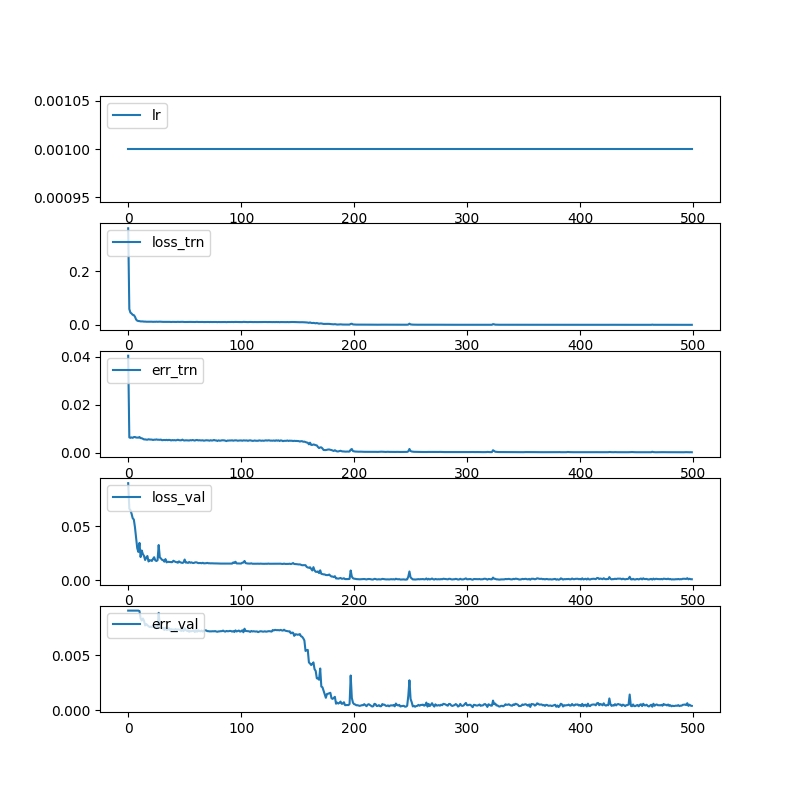

            lr   loss_trn    err_trn   loss_val    err_val
0      0.00100    0.36170    0.04034    0.08945    0.00909 - err decreased; checkpointing...
1      0.00100    0.05934    0.00631    0.06607    0.00909
2      0.00100    0.04591    0.00614    0.06458    0.00909
3      0.00100    0.04268    0.00634    0.06137    0.00909
4      0.00100    0.03776    0.00616    0.05721    0.00909
5      0.00100    0.03664    0.00646    0.05603    0.00909
6      0.00100    0.03081    0.00650    0.04893    0.00909
7      0.00100    0.02027    0.00628    0.03890    0.00909
8      0.00100    0.01597    0.00627    0.02976    0.00909
9      0.00100    0.01455    0.00623    0.02620    0.00908 - err decreased; checkpointing...
10     0.00100    0.01427    0.00649    0.03455    0.00905 - err decreased; checkpointing...
11     0.00100    0.01314    0.00603    0.02151    0.00839 - err decreased; checkpointing...
12     0.00100    0.01325    0.00598    0.02756    0.00818 - err decreased; checkpointing...
13  

128    0.00100    0.01054    0.00495    0.01537    0.00732
129    0.00100    0.01077    0.00507    0.01526    0.00728
130    0.00100    0.01042    0.00488    0.01541    0.00733
131    0.00100    0.01091    0.00513    0.01526    0.00731
132    0.00100    0.01049    0.00495    0.01530    0.00731
133    0.00100    0.01080    0.00512    0.01533    0.00731
134    0.00100    0.01021    0.00483    0.01527    0.00729
135    0.00100    0.01070    0.00508    0.01540    0.00733
136    0.00100    0.01062    0.00501    0.01523    0.00728
137    0.00100    0.01015    0.00477    0.01517    0.00726
138    0.00100    0.01044    0.00491    0.01548    0.00735
139    0.00100    0.01044    0.00490    0.01519    0.00726
140    0.00100    0.01047    0.00491    0.01520    0.00723
141    0.00100    0.01074    0.00504    0.01516    0.00721
142    0.00100    0.01034    0.00485    0.01522    0.00719
143    0.00100    0.01066    0.00498    0.01540    0.00720
144    0.00100    0.01064    0.00492    0.01507    0.007

249    0.00100    0.00470    0.00151    0.00828    0.00273
250    0.00100    0.00185    0.00066    0.00279    0.00103
251    0.00100    0.00127    0.00046    0.00185    0.00074
252    0.00100    0.00104    0.00039    0.00092    0.00035
253    0.00100    0.00090    0.00033    0.00098    0.00040
254    0.00100    0.00086    0.00032    0.00083    0.00032 - err decreased; checkpointing...
255    0.00100    0.00085    0.00032    0.00094    0.00039
256    0.00100    0.00075    0.00029    0.00096    0.00040
257    0.00100    0.00076    0.00029    0.00119    0.00049
258    0.00100    0.00073    0.00028    0.00103    0.00042
259    0.00100    0.00070    0.00027    0.00120    0.00049
260    0.00100    0.00063    0.00024    0.00117    0.00049
261    0.00100    0.00067    0.00026    0.00128    0.00051
262    0.00100    0.00064    0.00025    0.00099    0.00042
263    0.00100    0.00066    0.00025    0.00111    0.00046
264    0.00100    0.00065    0.00025    0.00184    0.00070
265    0.00100    0.00

387    0.00100    0.00044    0.00017    0.00114    0.00044
388    0.00100    0.00042    0.00017    0.00127    0.00046
389    0.00100    0.00071    0.00027    0.00126    0.00047
390    0.00100    0.00065    0.00025    0.00139    0.00052
391    0.00100    0.00051    0.00020    0.00105    0.00042
392    0.00100    0.00044    0.00018    0.00110    0.00043
393    0.00100    0.00041    0.00017    0.00176    0.00057
394    0.00100    0.00043    0.00017    0.00123    0.00045
395    0.00100    0.00044    0.00017    0.00116    0.00043
396    0.00100    0.00047    0.00018    0.00148    0.00053
397    0.00100    0.00046    0.00018    0.00150    0.00052
398    0.00100    0.00047    0.00019    0.00155    0.00053
399    0.00100    0.00041    0.00017    0.00115    0.00043
400    0.00100    0.00038    0.00016    0.00137    0.00049
401    0.00100    0.00038    0.00015    0.00098    0.00039
402    0.00100    0.00040    0.00016    0.00194    0.00058
403    0.00100    0.00043    0.00017    0.00095    0.000

In [13]:
%matplotlib notebook

# Training loop
df_metrics = pd.DataFrame(columns=['lr'] + 
                                  [str(key+'_trn') for key in metrics.keys()] +
                                  [str(key+'_val') for key in metrics.keys()])
m_checkpoint = np.inf # Initialize to arbitrarily high value
fig, axs = plt.subplots(df_metrics.shape[1], 1, figsize=(8,8))
for num_epoch in range(num_epochs):    
    # Train
    m_trn = train(model, dl_trn, loss, metrics, optimizer, device)
    
    # Validate
    m_val = validate(model, dl_val, loss, metrics, optimizer, device)
    
    # Step scheduler
    if schedule:
        scheduler.step(m_trn['loss'])
    
    # Store metrics
    df_metrics.loc[num_epoch, 'lr'] = np.mean([p['lr'] for p in optimizer.param_groups])
    for key, val in m_trn.items(): df_metrics.loc[num_epoch, key+'_trn'] = val
    for key, val in m_val.items(): df_metrics.loc[num_epoch, key+'_val'] = val
    
    # Print metrics
    print(df_metrics.iloc[[num_epoch]].to_string(header=num_epoch == 0,
                                                 float_format=lambda x: f'{x:10.5f}',
                                                 col_space=3), end='')
    
    # Checkpoint
    if m_val[metric_checkpoint] < m_checkpoint:
        print(f' - {metric_checkpoint} decreased; checkpointing...', end='')
        save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/best.pth'))
        m_checkpoint = m_val[metric_checkpoint]
    
    # Print newline
    print()
    
    # Plot stuff
    for idx, key in enumerate(df_metrics.columns):
        axs[idx].clear()
        axs[idx].plot(np.arange(num_epoch+1), df_metrics[key], label=key)
        axs[idx].legend(loc='upper left')
    fig.canvas.draw()
    
%matplotlib inline

# Test

In [ ]:
X, y = next(iter(dl_trn))
X, y = X.to(device), y.to(device)

In [ ]:
model.eval()
with torch.no_grad():
    y_hat = model(X)

In [ ]:
idx = 2

In [ ]:
plt.imshow(X[idx,0,:,:].cpu().detach())

In [ ]:
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx], vmin=0, vmax=4)

In [ ]:
plt.imshow(y.cpu().detach().numpy()[idx], vmin=0, vmax=4)

In [ ]:
files_img = [p for p in Path('data').glob('*.png') if not p.name.endswith('mask.png')]

In [ ]:
idx = 10
img = Image.open(files_img[idx])

In [ ]:
img = img.resize((512, 384))

In [ ]:
img = np.array(img)

In [ ]:
img = img.astype(np.float32)

In [ ]:
img /= img.max()

In [ ]:
img = normalize(img, [0, 1], [-1, 1])

In [ ]:
img.min(), img.max()

In [ ]:
plt.imshow(img, vmin=-1, vmax=1, cmap='gray')

In [ ]:
img = torch.tensor(img)[None][None]
img.shape

In [ ]:
img = img.to(device)

In [ ]:
model.eval()
with torch.no_grad():
    mask = model(img)

In [ ]:
mask = mask.argmax(dim=1).cpu().detach().numpy()[0]

In [ ]:
plt.imshow(mask, vmin=0, vmax=4)